In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, fbeta_score, precision_recall_curve
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('dataframe.csv')

In [3]:
df.columns

Index(['Datetime', 'Средняя температура', 'Минимальная температура',
       'Сумма минимальных температур', 'Максимальная температура',
       'Сумма максимальных температур', 'Сумма осадков',
       'Максимальное количество осадков',
       'Количество дней с суточными осадками более 1 мм',
       'Количество дней с суточными осадками более 10 мм',
       ...
       'Сумма осадков в дни с отрицательными температурами_в следующем месяце',
       'Сумма квадратов среднесуточных температур_в следующем месяце',
       'Сумма квадратов суточного количества осадков_в следующем месяце',
       'Количество переходов через 0°С_в следующем месяце',
       'Среднее изменение среднесуточных температур_в следующем месяце',
       'Среднее изменение суточного количества осадков_в следующем месяце',
       'month', 'ij_1', 'ij_2', 'ij_3'],
      dtype='object', length=221)

In [4]:
corr_1 = np.abs(df[df['month'] == 4].iloc[:,1:].corr()['ij_1']) #линейная корреляция Пирсона
corr_2 = np.abs(df[df['month'] == 3].iloc[:,1:].corr()['ij_2'])
corr_3 = np.abs(df[df['month'] == 2].iloc[:,1:].corr()['ij_3'])

In [5]:
corr_spearman_1 = np.abs(df[df['month'] == 4].iloc[:,1:].corr(method='spearman')['ij_1']) #ранговая корреляция Спирмена
corr_spearman_2 = np.abs(df[df['month'] == 3].iloc[:,1:].corr(method='spearman')['ij_2'])
corr_spearman_3 = np.abs(df[df['month'] == 2].iloc[:,1:].corr(method='spearman')['ij_3'])

In [6]:
corr_threshold = 0.15

In [7]:
features = set(np.concatenate([corr_1[corr_1 > corr_threshold].index, 
                               #corr_2[corr_2 > corr_threshold].index, 
                               #corr_3[corr_3 > corr_threshold].index,
                               corr_spearman_1[corr_spearman_1 > corr_threshold].index,
                               #
                               #corr_spearman_2[corr_spearman_2 > corr_threshold].index, 
                               #corr_spearman_3[corr_spearman_3 > corr_threshold].index
                              ]))

In [8]:
#features = corr_1[corr_1 > corr_threshold].index

In [9]:
features

{'ij_1',
 'mean_temp_amplitude',
 'mean_temp_amplitude_1 месяц назад',
 'mean_temp_amplitude_2 месяца назад',
 'mean_temp_amplitude_3 месяца назад',
 'mean_temp_amplitude_5 месяца назад',
 'mean_temp_amplitude_6 месяцев назад',
 'Количество дней с среднесуточной отрицательной температурой и наличием осадков_3 месяца назад',
 'Количество дней с среднесуточной отрицательной температурой и наличием осадков_в следующем месяце',
 'Количество дней с суточными осадками более 1 мм_6 месяцев назад',
 'Количество дней с суточными осадками более 10 мм_2 месяца назад',
 'Количество дней с суточными осадками более 10 мм_7 месяцев назад',
 'Количество дней со среднесуточной температурой выше 0°С_2 месяца назад',
 'Количество дней со среднесуточной температурой выше 0°С_в следующем месяце',
 'Количество дней со среднесуточной температурой ниже 0°С_1 месяц назад',
 'Количество дней со среднесуточной температурой ниже 0°С_4 месяца назад',
 'Количество дней со среднесуточной температурой ниже 0°С_в след

In [10]:
df[np.array(features)].to_csv('df.csv', index=False)

In [11]:
pppp = df[['Средняя температура', 'Сумма квадратов отрицательных температур', 'ij_1']]

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pppp, x='Сумма квадратов среднесуточных температур в текущем месяце, °С2', 
                y='Сумма квадратов среднесуточных температур 6 месяцев назад, °С2', 
                hue='Наличие/отсутвие ледового затора')

ValueError: Could not interpret value `Сумма квадратов среднесуточных температур в текущем месяце, °С2` for parameter `x`

<Figure size 800x600 with 0 Axes>

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours

In [ ]:
X = df.drop(['ij_1', 'ij_2','ij_3', 'Datetime'], axis=1)
y = df['ij_1']

In [13]:
df.drop(['ij_1'], axis=1)

,Datetime,Средняя температура,Минимальная температура,Сумма минимальных температур,Максимальная температура,Сумма максимальных температур,Сумма осадков,Максимальное количество осадков,Количество дней с суточными осадками более 1 мм,Количество дней с суточными осадками более 10 мм,...,Сумма квадратов положительных температур_в следующем месяце,Сумма осадков в дни с отрицательными температурами_в следующем месяце,Сумма квадратов среднесуточных температур_в следующем месяце,Сумма квадратов суточного количества осадков_в следующем месяце,Количество переходов через 0°С_в следующем месяце,Среднее изменение среднесуточных температур_в следующем месяце,Среднее изменение суточного количества осадков_в следующем месяце,month,ij_2,ij_3
0,1926-01-01,-16.500000,-21.400000,-663.4,-11.800000,-365.8,9.3,0.3,0,0,...,0.000000,5.6,7078.680000,1.12,0.0,0.000000,0.000000e+00,1,0.0,0.0
1,1926-02-01,-15.900000,-20.800000,-582.4,-11.600000,-324.8,5.6,0.2,0,0,...,0.000000,6.2,4614.040000,1.24,0.0,0.000000,0.000000e+00,2,0.0,0.0
2,1926-03-01,-12.200000,-17.700000,-548.7,-7.300000,-226.3,6.2,0.2,0,0,...,0.000000,3.0,874.800000,0.30,0.0,0.000000,0.000000e+00,3,0.0,0.0
3,1926-04-01,-5.400000,-9.800000,-294.0,-1.000000,-30.0,3.0,0.1,0,0,...,0.000000,0.0,0.000000,0.31,0.0,0.000000,0.000000e+00,4,0.0,0.0
4,1926-05-01,0.000000,-2.400000,-74.4,3.000000,93.0,3.1,0.1,0,0,...,1598.700000,0.0,1598.700000,0.00,0.0,0.000000,0.000000e+00,5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2022-08-01,15.367339,10.667742,330.7,19.519355,605.1,39.6,16.0,5,1,...,1613.876406,0.0,1624.558906,401.02,0.0,-0.256897,0.000000e+00,8,0.0,0.0
1160,2022-09-01,6.211250,3.646667,109.4,8.963333,268.9,62.0,10.5,11,1,...,616.041562,11.5,676.058906,239.69,0.0,-0.061667,-6.666667e-02,9,0.0,0.0
1161,2022-10-01,3.021371,1.116129,34.6,4.596774,142.5,53.7,8.0,14,0,...,0.743906,30.2,1648.339219,85.29,0.0,-0.309483,-7.241379e-02,10,0.0,0.0
1162,2022-11-01,-6.265417,-9.200000,-276.0,-3.726667,-111.8,30.9,5.0,9,0,...,0.000000,10.7,6903.979066,9.39,0.0,-0.329167,-3.700743e-18,11,0.0,0.0


In [15]:
sampler = SMOTE()
X_train_oversampled, y_train_oversampled = sampler.fit_resample(pppp.drop(['ij_1'], axis=1), pppp['ij_1'])

In [23]:
X_train_oversampled['ij_1'] = y_train_oversampled

In [25]:
X_train_oversampled = X_train_oversampled[X_train_oversampled['ij_1'] > 0]

In [31]:
uuu = X_train_oversampled.loc[1144:,:]

In [32]:
uuu['ij_1'] = '1(SMOTE)'

C:\Users\s.iglin\AppData\Local\Temp\ipykernel_17544\1180422405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uuu['ij_1'] = '1(SMOTE)'


In [20]:
pppp['ij_1'] = pppp['ij_1'].astype(int)

C:\Users\s.iglin\AppData\Local\Temp\ipykernel_17544\2404492542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pppp['ij_1'] = pppp['ij_1'].astype(int)


In [52]:
ccc = pd.concat([pppp, uuu])

In [54]:
ccc.columns = ['Средняя температура', 'Сумма квадратов отрицательных температур',
       'Наличие/отсутвие ледового затора']

In [92]:
ccc['Наличие/отсутвие ледового затора']=ccc['Наличие/отсутвие ледового затора'].astype(str)

In [101]:
ccc = ccc.sort_values('Наличие/отсутвие ледового затора', ascending=False)

In [106]:
ccc = pd.concat([ccc[ccc['Наличие/отсутвие ледового затора']=='0'], ccc[ccc['Наличие/отсутвие ледового затора']=='1(SMOTE)'], ccc[ccc['Наличие/отсутвие ледового затора']=='1']])

<Axes: xlabel='Средняя температура', ylabel='Сумма квадратов отрицательных температур'>

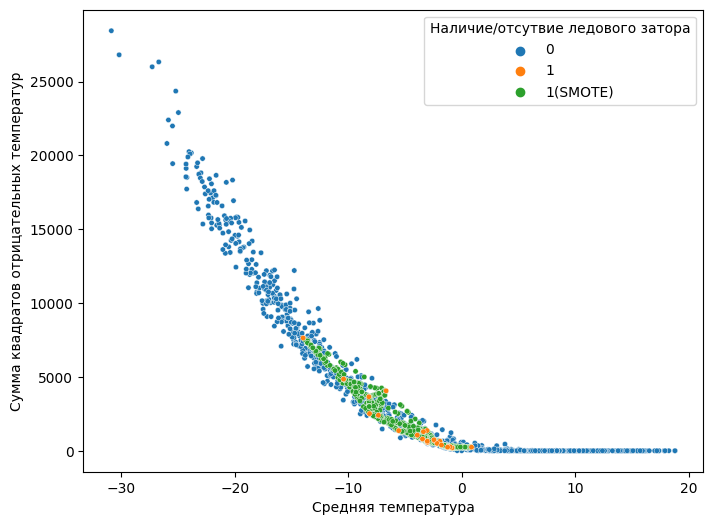

In [108]:
io = ['0', '1', '1(SMOTE)']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ccc,  x='Средняя температура', 
                y='Сумма квадратов отрицательных температур', 
                hue='Наличие/отсутвие ледового затора',
               hue_order=io,
                s=15)

<Figure size 1600x900 with 0 Axes>

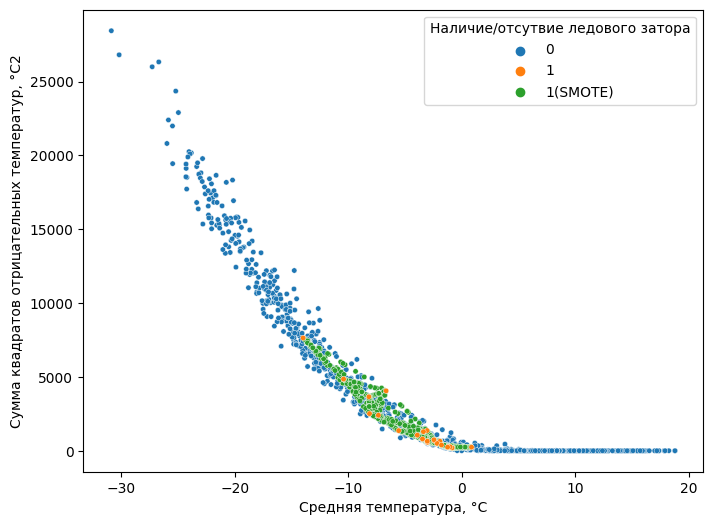

In [115]:
# Import libraries
import seaborn as sns # for Data visualization
import matplotlib.pyplot as plt # for Data visualization
 
plt.figure(figsize = (16,9)) # figure size in 16:9 ratio

 
io = ['0', '1', '1(SMOTE)']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ccc,  x='Средняя температура', 
                y='Сумма квадратов отрицательных температур', 
                hue='Наличие/отсутвие ледового затора',
               hue_order=io,
                s=15)
 

plt.xlabel("Средняя температура, °С") # x-axis label
plt.ylabel("Сумма квадратов отрицательных температур, °С2") # y-axis label
plt.savefig("Scatter Plot of Tip and Total Bill") # save generated scatter plot at program location
plt.show() # show scatter plot